run cell below and restart runtime

In [1]:
!pip install transformers[torch] accelerate -U
!pip install datasets
!pip install transformers
!pip install -q transformers
!pip install -q clean-text[gpl]
!pip install iterative-stratification
!pip install hazm
!pip install tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 583.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.3/324.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 40.5 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.32.1
    Uninstalling accelerate-0.32.1:
      Successfully uninstalled accelerate-0.32.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.3 MB/s eta 0:00:00
  Attemptin

#initial setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import os
from os import path
import seaborn as sns
from tqdm.notebook import tqdm
import hazm
from cleantext import clean
import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from tqdm import tqdm
import re
import json
import copy
import collections
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset,load_dataset, DatasetDict
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import classification_report,accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from scipy.special import expit  # This is the sigmoid function

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [6]:
pip show transformers accelerate

Name: transformers
Version: 4.44.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 
---
Name: accelerate
Version: 0.34.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


#Models

*   List models



In [ ]:
# fasttext              facebook/fasttext-language-identification
# HAN                   microsoft/trocr-base-handwritten

# RCNN
# RCNNVariant
# TextAttBiRNN
# TextBiRNN
# TextRNN

# ParsBERT              HooshvareLab/bert-fa-base-uncased         HooshvareLab/bert-base-parsbert-uncased     HooshvareLab/bert-fa-base-uncased-ner-peyma
# XLM-Roberta-base      FacebookAI/xlm-roberta-base
# XLM-Roberta-large     FacebookAI/xlm-roberta-large
# XLM-EMO-T             MilaNLProc/xlm-emo-t

# bert                      google-bert/bert-base-multilingual-uncased
# distil-roberta-base       distilbert/distilroberta-base
# distil-bert               distilbert/distilbert-base-uncased
#distil-bert multilingual   distilbert/distilbert-base-multilingual-cased
#DeBERTAV3                  microsoft/mdeberta-v3-base
#DeBERTA-base               microsoft/deberta-base
#albert-base                albert/albert-base-v2
#xlnet-base                 xlnet/xlnet-base-cased
#t5                         google-t5/t5-base


In [7]:
models_list=[
            "facebook/fasttext-language-identification",
             "microsoft/trocr-base-handwritten",
             "HooshvareLab/bert-fa-base-uncased",
             "FacebookAI/xlm-roberta-base",
             "FacebookAI/xlm-roberta-large",
             "MilaNLProc/xlm-emo-t",
             "google-bert/bert-base-multilingual-uncased",
             "distilbert/distilroberta-base",
             "distilbert/distilbert-base-uncased",
             "distilbert/distilbert-base-multilingual-cased",
             "distilbert/distilbert-base-multilingual-cased",
             "microsoft/mdeberta-v3-base",
             "microsoft/deberta-base",
             "albert/albert-base-v2",
             "xlnet/xlnet-base-cased",
             "google-t5/t5-base",
             ]

models_name=[
"fasttext",
"HAN",
"ParsBERT",
"XLM-Roberta-base",
"XLM-Roberta-large",
"XLM-EMO-T",
"bert",
"distil-roberta-base",
"distil-bert",
"distil-bert multilingual",
"DeBERTAV3",
"DeBERTA-base",
"albert-base",
"xlnet-base",
"t5",
]



#Load Data

In [8]:
#fill with the dataset address
base_data=pd.read_csv("/content/drive/MyDrive/chatbot dataset/final_labeled_chats.csv")
base_data=base_data.drop(columns={'Unnamed: 8','relative_message'})
base_data

,username,created_at,message,response,emotion,disorder,validation,label,related,not-related
0,test2,2024-08-11 10:27:42.951347+00:00,سلام,از این که با من در میان گذاشتید خوشحالم. چطور ...,"{'OTHER': 0.01733604446053505, 'HAPPY': 0.6017...","{'Not Stressed': 0.9525769352912903, 'Stressed...",[],1,1,0
1,test2,2024-08-11 10:28:00.300694+00:00,اسم تو چیست,به من می‌توانید با عنوان راهنما یاد کنید. من ا...,"{'OTHER': 0.022789059206843376, 'HAPPY': 0.060...","{'Not Stressed': 0.9497029185295105, 'Stressed...",[],1,1,0
2,test2,2024-08-11 10:28:51.753344+00:00,امروز کمی سردرد دارم,متوجه شدم که امروز کمی سردرد دارید. گاهی اوقات...,"{'OTHER': 0.478849321603775, 'HAPPY': 0.054604...","{'Not Stressed': 0.10206229239702225, 'Stresse...",[],1,1,0
3,test2,2024-08-11 10:29:44.775521+00:00,امروز کمی سردرد دارم,احساس ناراحتی که شما تجربه می‌کنید می‌تواند بی...,"{'OTHER': 0.478849321603775, 'HAPPY': 0.054604...","{'Not Stressed': 0.10206229239702225, 'Stresse...",[],1,1,0
4,test2,2024-08-11 10:30:43.400752+00:00,امروز کمی سردرد دارم,طبق اطلاعاتی که در دست دارم، متوجه شده‌ام که م...,"{'OTHER': 0.478849321603775, 'HAPPY': 0.054604...","{'Not Stressed': 0.10206229239702225, 'Stresse...",[],1,1,0
...,...,...,...,...,...,...,...,...,...,...
1257,علی,2024-08-29 22:31:33.683202+00:00,فکر میکنم کسی به من اهمیتی نمیده,متأسفم که این حس رو داری. می‌دونم که گاهی بیشت...,"{'OTHER': 0.8344117999076843, 'HAPPY': 0.01260...","{'Not Stressed': 0.028578927740454674, 'Stress...",[],1,1,0
1258,علی,2024-08-29 22:32:41.656825+00:00,فکر میکنم دوستام برای من ارزشی قائل نیستن,می‌فهمم چه احساسی داری. گاهی آدم‌ها مشغله‌های ...,"{'OTHER': 0.8188485503196716, 'HAPPY': 0.01676...","{'Not Stressed': 0.39618656039237976, 'Stresse...",[],1,1,0
1259,علی,2024-08-29 22:33:41.510656+00:00,چیکار کنم مادرم خوشحال کنم,می‌دونم که خوشحال کردن مادرت برات خیلی مهمه. ش...,"{'OTHER': 0.5356032252311707, 'HAPPY': 0.34640...","{'Not Stressed': 0.0787871852517128, 'Stressed...",[],1,1,0
1260,علی,2024-08-29 22:34:18.723609+00:00,داشتن مدیریت مالی,به نظر میاد که مدیریت مالی برات داره استرس ایج...,"{'OTHER': 0.01191758830100298, 'HAPPY': 0.0419...","{'Not Stressed': 0.9203130006790161, 'Stressed...",[],1,1,0


In [9]:
type(base_data.iloc[0].message)

str

In [10]:
base_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   username     1262 non-null   object
 1   created_at   1262 non-null   object
 2   message      1262 non-null   object
 3   response     1262 non-null   object
 4   emotion      1262 non-null   object
 5   disorder     1262 non-null   object
 6   validation   1262 non-null   object
 7   label        1262 non-null   int64 
 8   related      1262 non-null   int64 
 9   not-related  1262 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 98.7+ KB


In [11]:
base_data.head()

,username,created_at,message,response,emotion,disorder,validation,label,related,not-related
0,test2,2024-08-11 10:27:42.951347+00:00,سلام,از این که با من در میان گذاشتید خوشحالم. چطور ...,"{'OTHER': 0.01733604446053505, 'HAPPY': 0.6017...","{'Not Stressed': 0.9525769352912903, 'Stressed...",[],1,1,0
1,test2,2024-08-11 10:28:00.300694+00:00,اسم تو چیست,به من می‌توانید با عنوان راهنما یاد کنید. من ا...,"{'OTHER': 0.022789059206843376, 'HAPPY': 0.060...","{'Not Stressed': 0.9497029185295105, 'Stressed...",[],1,1,0
2,test2,2024-08-11 10:28:51.753344+00:00,امروز کمی سردرد دارم,متوجه شدم که امروز کمی سردرد دارید. گاهی اوقات...,"{'OTHER': 0.478849321603775, 'HAPPY': 0.054604...","{'Not Stressed': 0.10206229239702225, 'Stresse...",[],1,1,0
3,test2,2024-08-11 10:29:44.775521+00:00,امروز کمی سردرد دارم,احساس ناراحتی که شما تجربه می‌کنید می‌تواند بی...,"{'OTHER': 0.478849321603775, 'HAPPY': 0.054604...","{'Not Stressed': 0.10206229239702225, 'Stresse...",[],1,1,0
4,test2,2024-08-11 10:30:43.400752+00:00,امروز کمی سردرد دارم,طبق اطلاعاتی که در دست دارم، متوجه شده‌ام که م...,"{'OTHER': 0.478849321603775, 'HAPPY': 0.054604...","{'Not Stressed': 0.10206229239702225, 'Stresse...",[],1,1,0


#Preprocess

In [12]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()

    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)

    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)

    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)

    text = wierd_pattern.sub(r'', text)

    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)

    return text

**Normalize** and clean textS

In [ ]:
tqdm.pandas()

base_data['clean_message'] = base_data['message'].progress_apply(cleaning)
base_data['cleaned_text_len_by_words'] = base_data['clean_message'].progress_apply(lambda t: len(hazm.word_tokenize(t)))

 83%|████████▎ | 1053/1262 [40:16<08:35,  2.47s/it]

In [ ]:
# base_data_fa = base_data.dropna(subset=['cleaned_farsi_text_len_by_words'])
base_data_fa = base_data.reset_index(drop=True)

In [ ]:
base_data_fa.head()

In [ ]:
base_data_fa.to_csv("/content/drive/MyDrive/generalize-v2.csv")

In [ ]:
data_counts=base_data_fa['label'].value_counts()
data_counts

Define a regex pattern that matches anything that is not a Persian letter, English letter, or space


In [ ]:
temp_data=base_data_fa
pattern = r'[^a-zA-Z\u0600-\u06FF\s]'
temp_data['clean_message_more'] = temp_data['clean_message'].str.replace(pattern, " ")
temp_data

In [ ]:
temp_data.head()

Tokenize texts

In [ ]:
temp_data['clean_tokenize_message']=temp_data['clean_message_more'].apply(lambda message : hazm.word_tokenize(message))
temp_data

In [ ]:
temp_data.head()

use Stemmer on message

In [ ]:
stemmer=hazm.Stemmer()
temp_data['clean_tokenize_message']=temp_data['clean_tokenize_message'].apply(lambda message : stemmer(message))
temp_data

In [ ]:
temp_data.head()

now attach tokens together again

In [ ]:
temp_data['clean_tokenize_message']=temp_data['clean_tokenize_message'].apply(lambda words_t : ' '.join([word for word in words_t]))
temp_data

In [ ]:
temp_data.head()

#process dataset

<Figure size 800x800 with 0 Axes>

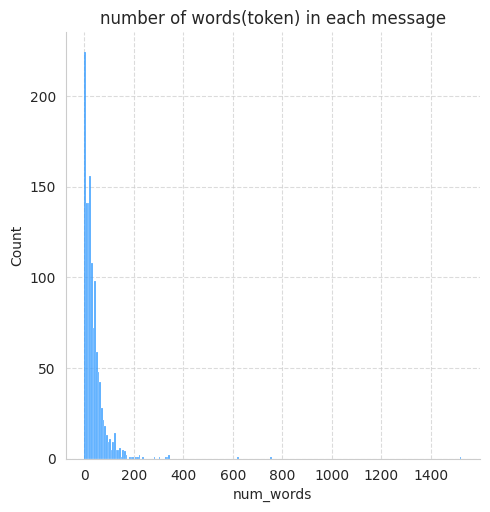

In [18]:
base_data_fa['num_words']=base_data_fa['message'].str.len()
fig=plt.figure(figsize=(8,8))
sns.set_style('dark')  # Options: 'white', 'dark', 'whitegrid', 'darkgrid', 'ticks'

sns.displot(base_data_fa['num_words'], color='dodgerblue')
plt.title('number of words(token) in each message')

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [21]:
big_len=base_data_fa['message'].where(base_data_fa['message'].str.len()>350)
big_len

,message
0,False
1,False
2,False
3,False
4,False
...,...
1257,False
1258,False
1259,False
1260,False


#Train Model

In [ ]:
#update label column name
label_columns = ['related', 'not-related']

y = base_data_fa[label_columns].values

mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=1)
train_indices, valid_indices = next(mskf.split(base_data_fa, y))

train = base_data_fa.iloc[train_indices].reset_index(drop=True)
valid = base_data_fa.iloc[valid_indices].reset_index(drop=True)

x_train, y_train = train['clean_text'].values.tolist(), train[label_columns].values.tolist()
x_valid, y_valid = valid['clean_text'].values.tolist(), valid[label_columns].values.tolist()

y_train_df = pd.DataFrame(y_train, columns=label_columns)

label_distribution = y_train_df.apply(pd.Series.value_counts).T.fillna(0).astype(int)
label_distribution.columns = ['count_0', 'count_1']
print(label_distribution)

In [ ]:
y_valid_df = pd.DataFrame(y_valid, columns=label_columns)
label_distribution_valid = y_valid_df.apply(pd.Series.value_counts).T.fillna(0).astype(int)
label_distribution_valid.columns = ['count_0', 'count_1']

print(label_distribution_valid)

In [ ]:
len(x_train)

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)  # Ensure labels are float tensors
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
def build_dataset(x_train,y_train,x_valid,y_valid,MAX_LENGTH):
  train_encodings = tokenizer(x_train, truncation=True, padding="max_length", max_length=MAX_LENGTH)
  valid_encodings = tokenizer(x_valid, truncation=True, padding="max_length", max_length=MAX_LENGTH)
  train_dataset = Dataset(train_encodings, y_train)
  valid_dataset = Dataset(valid_encodings, y_valid)
  return train_dataset,valid_dataset

def train_arg():
    training_args = TrainingArguments(
    output_dir="./output/best-model-v1",
    report_to=None,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    evaluation_strategy="steps",
    save_total_limit=1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
  )
    return training_args

In [ ]:
def evaluate_func(trainer):
  trainer.evaluate()
  # Get predictions from the model
  predictions = trainer.predict(valid_dataset)
  predicted_logits = predictions.predictions
  # Apply sigmoid to get probabilities
  predicted_probabilities = expit(predicted_logits)  # Apply sigmoid to the logits
  # Apply threshold to get binary predictions
  threshold = 0.5
  predicted_classes = (predicted_probabilities >= threshold).astype(int)
  precision, recall, f1, _ = precision_recall_fscore_support(y_valid, predicted_classes, average=None)
  accuracy = accuracy_score(y_valid, predicted_classes)
  return precision, recall, f1,accuracy

In [ ]:
MAX_LENGTH = 256

metrics_df = pd.DataFrame(columns=["Models_name", "Precision", "Recall", "F1_score", "Accuracy"])

confusion_matrices = []

In [ ]:

for i in range(models_list):
  tokenizer = AutoTokenizer.from_pretrained(i)
  model = AutoModelForSequenceClassification.from_pretrained(i, num_labels=2, ignore_mismatched_sizes=True)
  training_args = train_arg()
  train_dataset,valid_dataset=build_dataset(x_train,y_train,x_valid,y_valid,MAX_LENGTH)
  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=valid_dataset,
  )
  trainer.train()
  precision, recall, f1,accuracy=evaluate_func(trainer)
  new_data = pd.DataFrame
   ({
    "Models_name": [models_name[i]],
    "Precision": [precision],
    "Recall": [recall],
    "F1_score": [f1],
    "Accuracy": [accuracy]
  })

  metrics_df = pd.concat([metrics_df, new_data], ignore_index=True)

  model_confusion_matrices = []
  predicted_classes = trainer.predict(valid_dataset).predictions
  predicted_classes = (expit(predicted_classes) >= 0.5).astype(int)
  for j in range(len(label_columns)):
      cm = confusion_matrix(y_valid[:, j], predicted_classes[:, j])
      model_confusion_matrices.append(cm)

  confusion_matrices.append(model_confusion_matrices)


  print(f"{models_name[i]} evaluates:")
  for i, label in enumerate(label_columns):
    print(f"Class '{label}': Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1[i]:.4f}")
  print(f"Overall accuracy: {accuracy:.4f}")
  print("-------------------------------------------------------------------------\n")

#Show confusion matrix

In [ ]:
for model_idx, model_cms in enumerate(confusion_matrices):
    for label_idx, cm in enumerate(model_cms):
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
        plt.title(f'Confusion Matrix for Model {models_name[model_idx]} - Class {label_columns[label_idx]}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()